In [1]:
!pip install pytorch_lightning
!pip install tensorboardX

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 527 kB 700 kB/s eta 0:00:01
     |████████████████████████████████| 5.9 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 952 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 840 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 289 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 2.6 MB/s eta 0:00:01     |█████████████▉                  | 2.1 MB 2.3 MB/s eta 0:00:02
     |████████████████████████████████| 151 kB 3.8 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=494240 sha256=35a6005aa44653c3e3151d583ca777548304ad673f2108bf877f2d014ad2e1d6
  Stored in directory: /home/zomb-clyo-gpu1/.cache/pip/wheels/63/f1/0c/e56d12b3804345ce5ba3

In [147]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DATA_DIR = "/content/drive/MyDrive/recsys-itmo-2023/seminar_05/"

In [3]:
data = pd.read_json("data_seminar_04.json", lines=True)

In [29]:
data.shape

(815255, 8)

In [148]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,last,2022-06-13 11:39:37.645,4013,18934,0.02,0.000206,NaN,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
1,next,2022-06-13 11:39:37.683,9693,29738,1.00,0.000902,3079.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
2,next,2022-06-13 11:39:37.692,9693,3079,0.06,0.000923,20078.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
3,next,2022-06-13 11:39:37.700,9693,20078,1.00,0.000858,12044.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
4,next,2022-06-13 11:39:37.708,9693,12044,0.00,0.000927,37424.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"


In [149]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    first_time = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
            first_time = row["time"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        if row["time"] >= 0.8:
            first = row["track"]
            first_time = row["time"]
        
        if row["message"] == "last":
            first = None
            first_time = None
    return pairs

In [150]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

In [151]:
pairs.head()

,user,start,track,time
0,0,2999,5089,0.0
1,0,2999,5992,0.0
2,0,2999,7960,0.0
3,0,2999,1725,0.0
4,0,2999,2606,0.0


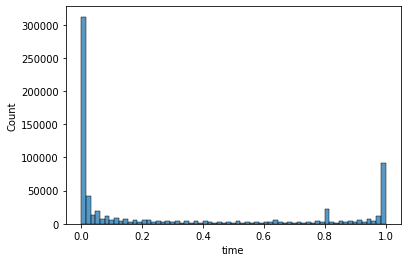

In [152]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [153]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572587, 70915, 71742)

In [154]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
        return torch.sum(context * track, dim=1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [155]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values), 
                torch.from_numpy(self.train_data["time"].values)
                )

            self.val_dataset = td.TensorDataset(
                torch.from_numpy(self.val_data[self.features].values), 
                torch.from_numpy(self.val_data["time"].values)
                )
        
        if stage == "test" or stage is None:  
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
            )
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [156]:
net = ContextualRanker(embedding_dim=100)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [18]:
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs --host localhost

In [157]:
trainer.fit(
    net, 
    data_module
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type      | Params
--------------------------------------
0 | context | Embedding | 5.0 M 
1 | track   | Embedding | 5.0 M 
--------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params
40.000    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/zomb-clyo-gpu1/.local/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/zomb-clyo-gpu1/.local/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   123: reducing learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   130: reducing learning rate of group 0 to 1.0000e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [158]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=100)

In [159]:
trainer.test(best, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/zomb-clyo-gpu1/.local/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_loss': 0.15447917580604553,
 'rdm_loss': 0.27846571803092957,
 'test_loss': 0.13623225688934326}
--------------------------------------------------------------------------------


[{'test_loss': 0.13623225688934326,
  'avg_loss': 0.15447917580604553,
  'rdm_loss': 0.27846571803092957}]

## Compute top recommendations

In [160]:
track_meta = pd.read_json("tracks.json", lines=True)

In [161]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [50]:
track_embeddings

array([[-5.522896e-40,  1.843735e-39,  9.966917e-40, ..., -4.667977e-40,
        -8.237239e-40, -8.815400e-40],
       [-8.910871e-40,  8.770657e-40,  8.661804e-40, ...,  1.595322e-40,
         1.017411e-39,  1.381973e-39],
       [-1.570008e-39,  2.957637e-40, -8.251742e-40, ..., -1.510593e-39,
        -1.951846e-39,  1.397380e-39],
       ...,
       [ 4.860670e-40,  3.669566e-40,  4.031115e-41, ...,  1.513251e-39,
         1.390580e-39,  3.440398e-40],
       [-5.783285e-40, -6.227076e-40, -7.025312e-40, ..., -1.140790e-39,
        -6.687010e-40, -8.769900e-40],
       [ 7.039619e-40, -4.574539e-41, -1.436307e-39, ..., -1.028042e-39,
         1.321678e-39, -1.864135e-39]], dtype=float32)

In [162]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [163]:
k = 100
with open("tracks_with_recs_with_new_pairs08.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

50000it [09:23, 88.79it/s] 


In [26]:
track = 3916
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

,artist,title
3916,Florence + The Machine,Bird Song


In [27]:
k = 10
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]

,artist,title
162,Train,Hey_ Soul Sister
388,Metric,Gold Guns Girls
410,Jason Mraz & Colbie Caillat,Lucky (Album Version)
442,Taylor Swift,Love Story
1075,Taylor Swift,Tim McGraw
1083,Kid Cudi / MGMT / Ratatat,Pursuit Of Happiness (nightmare)
1115,Emmy The Great,Mia
1179,Lady GaGa,Alejandro
3172,Arcade Fire,Ocean Of Noise
3648,Radiohead,15 Step
